In [1]:
from pylablib.devices import Thorlabs
import matplotlib.pyplot as plt
import cv2 as cv
from camera_controllers import CameraController
import time
import matplotlib.animation as animation
import numpy as np

# 1. Camera

In [114]:
depth_measurements = []
current_depth_measurements = {}
index = 20

In [233]:
camera = CameraController("IDS", 2)

In [373]:
camera.get_camera_ready()
cam_params = {"exposure": 8000}
camera.set_properties(cam_params)

In [235]:
device = Thorlabs.list_kinesis_devices()[0][0]
stage = Thorlabs.KinesisMotor(device)

stage.setup_velocity(min_velocity = 0, max_velocity = 100000000, acceleration = 1000000000)

c:\Users\tomas\miniconda3\envs\experimental_env\lib\site-packages\pylablib\devices\Thorlabs\kinesis.py:230: UserWarning: model number SCC201 doesn't match the device ID prefix 40((BSC101|SSC20.))
  warnings.warn("model number {} doesn't match the device ID prefix {}({})".format(model_no,port,port_model_no))
c:\Users\tomas\miniconda3\envs\experimental_env\lib\site-packages\pylablib\devices\Thorlabs\kinesis.py:1319: UserWarning: can't recognize motor model SCC201; setting all scales to internal units
  warnings.warn("can't recognize motor model {}; setting all scales to internal units".format(self._model))


TVelocityParams(min_velocity=0, acceleration=1000000000, max_velocity=100000000)

In [220]:
scale = 409600E-3 


def find_optimal_focus(depth_um, um_step, s_hole, s_patch, masks, blur = 5):
    assert um_step < depth_um
    init_position = stage.get_position()
    focus_hole = []
    focus_patch = []
    depths = []
    pos = 0
    while depth_um - pos > 0:
        image = (camera.get_image()*255).astype(np.uint8)
        image_hole = image[masks[0].astype(bool)]
        image_hole = image_hole.reshape(s_hole, s_hole)

        image_patch = image[masks[1].astype(bool)]
        image_patch = image_patch.reshape(s_patch, s_patch)

        f_metric_hole = calculate_focus_score(image_hole, blur)
        focus_hole.append(f_metric_hole)

        f_metric_patch = calculate_focus_score(image_patch, blur)
        focus_patch.append(f_metric_patch)

        depths.append(pos)
        pos += um_step
        stage.move_by(um_step*scale, scale = False)
        time.sleep(0.3)
    stage.move_to(init_position)
    return np.array(focus_hole), np.array(focus_patch), np.array(depths)

In [222]:
from scipy.interpolate import interp1d
def interpolate(original_x, original_y, n_points):
    f = interp1d(original_x, original_y)
    x_new = np.linspace(original_x.min(), original_x.max(), n_points)
    y_new = f(x_new)

    return x_new,  y_new

In [221]:
def calculate_focus_score(image, blur):
   image_filtered = cv.medianBlur(image, blur)
   laplacian = cv.Laplacian(image_filtered, cv.CV_64F)
   focus_score = laplacian.var()
   return focus_score

In [209]:
%matplotlib widget
def get_frame():
    img = camera.get_image()
    return img


masks = []

x_size = 1600
y_size = 1200
s_hole = 50
s_patch = 200
eps = 300

def get_masks_focus(s_hole, s_patch, x_size, y_size):
    fig, ax = plt.subplots()
    im = ax.imshow(get_frame(), cmap = 'gray')
    masks = []

    # Update function for the animation
    def update_frame(*args):
        im.set_array(get_frame())
        return im

    def onclick(event):
        if event.xdata is not None and event.ydata is not None:
            x, y = int(event.xdata), int(event.ydata)
            ax.scatter(x, y, marker = 'x', color = 'r')
            mask_template = np.zeros((y_size, x_size))
            mask_hole = mask_template.copy()
            mask_patch = mask_template.copy()

            mask_hole[y - s_hole//2: y + s_hole//2, x - s_hole//2 : x + s_hole//2] = 1
            masks.append(mask_hole)
            ax.imshow(mask_hole, alpha = 0.25)

            mask_patch[(y - eps) - s_patch//2: (y - eps) + s_patch//2, (x) - s_patch//2 : (x)  + s_patch//2] = 1
            masks.append(mask_patch)
            ax.imshow(mask_patch, alpha = 0.25)

    # Create an animation object
    ani = animation.FuncAnimation(fig, update_frame, interval = 10, blit = True, cache_frame_data = False)
    fig.canvas.mpl_connect('button_press_event', onclick)
    plt.show
    return masks, ani

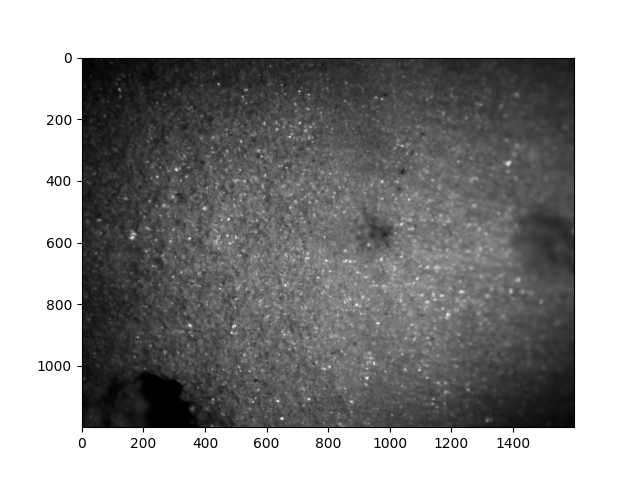

In [585]:
masks, _ = get_masks_focus(s_hole, s_patch, x_size, y_size)

In [577]:
stage.move_by(-600*scale, scale = False)

In [578]:
plt.close("all")

# 2. Stages

# 2. Find Depth

In [580]:
f_hole, f_patch, depths = find_optimal_focus(700, 15, s_hole, s_patch, masks)

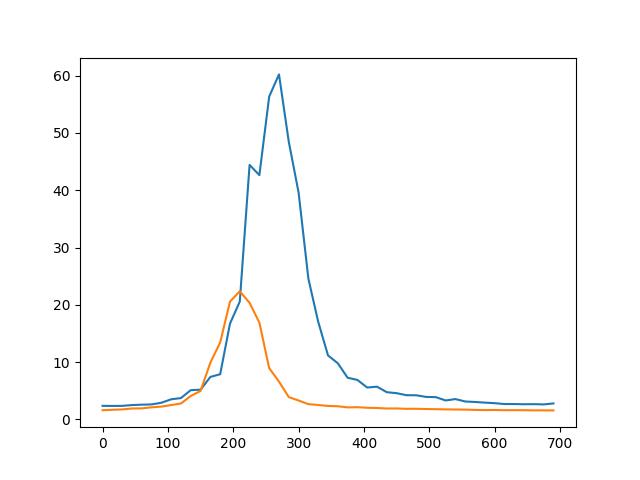

In [581]:
plt.subplots()
plt.plot(depths, f_hole)
plt.plot(depths, f_patch)

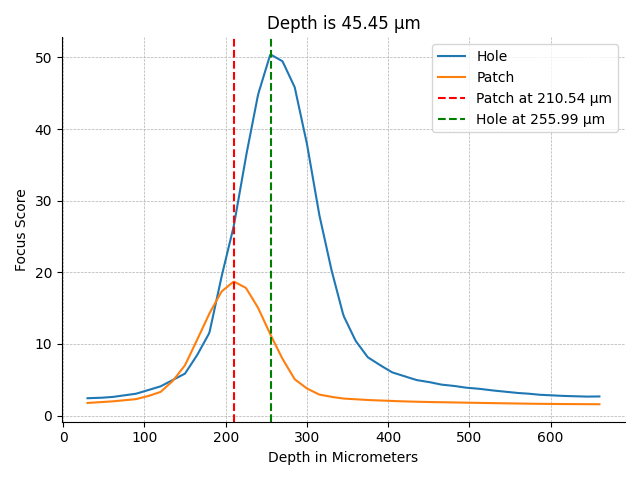

In [582]:
# Rolling Window Average
window_size = 5
smoothed_f_hole = moving_average(f_hole, window_size)
smoothed_f_patch = moving_average(f_patch, window_size)
adjusted_depths = depths[(window_size-1)//2 : -(window_size-1)//2]

# Interpolate
n_points = 500
new_depths, interpolated_f_hole = interpolate(adjusted_depths, smoothed_f_hole, n_points)
new_depths, interpolated_f_patch = interpolate(adjusted_depths, smoothed_f_patch, n_points)

# Find Maximums
focus_patch = new_depths[np.argmax(interpolated_f_patch)]
focus_hole = new_depths[np.argmax(interpolated_f_hole)]

# Depth
depth = abs(focus_hole - focus_patch)

fig, ax = plt.subplots()

ax.plot(new_depths, interpolated_f_hole, label = 'Hole')
ax.plot(new_depths, interpolated_f_patch, label = 'Patch')

# Maximum Plot
ax.axvline(focus_patch, color = 'red', linestyle = '--', label = f'Patch at {focus_patch:.2f} µm')
ax.axvline(focus_hole, color = 'green', linestyle = '--', label = f'Hole at {focus_hole:.2f} µm')

ax.set_xlabel('Depth in Micrometers')
ax.set_ylabel('Focus Score')

# Remove right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Add a grid for better readability
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

# Add a title
ax.set_title(f'Depth is {depth:.2f} µm')

ax.legend()
fig.tight_layout()
fig.savefig(f"Graphs/line_0_{index}_depth.jpg", dpi = 200)

In [583]:
current_depth_measurements.update({f"N_shots {index}": depth})
index -= 1

In [586]:
current_depth_measurements

{'N_shots 20': 429.85971943887773,
 'N_shots 19': 0,
 'N_shots 18': 314.3687374749499,
 'N_shots 17': 390.1202404809619,
 'N_shots 16': 300.48096192384764,
 'N_shots 15': 148.97795591182364,
 'N_shots 14': 374.9699398797595,
 'N_shots 13': 285.3306613226453,
 'N_shots 12': 361.0821643286573,
 'N_shots 11': 253.76753507014027,
 'N_shots 10': 239.87975951903806,
 'N_shots 9': 314.36873747494985,
 'N_shots 8': 133.8276553106212,
 'N_shots 7': 29.038076152304598,
 'N_shots 6': 45.450901803607195}

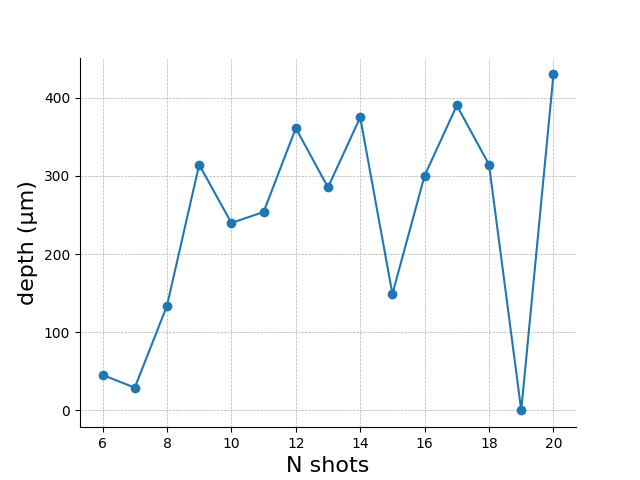

In [587]:
fig, ax = plt.subplots()
x = np.arange(6, 21)[::-1]
ax.plot(x, np.array(list(current_depth_measurements.values())), marker = 'o')
ax.set_xlabel("N shots", fontsize = 16)
ax.set_ylabel("depth (µm)", fontsize = 16)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.grid(True, which='both', linestyle='--', linewidth=0.5)

In [355]:
depth_measurements.append(current_depth_measurements)
current_depth_measurements = {}
index = 20

In [231]:
stage.close()
camera.close()